In [230]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sn
from tqdm import tqdm
%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [231]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [232]:
data_path = '/tf/data/dementia/0extra/ADReSS-IS2020-data/train'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [233]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [234]:
AUTOTUNE = tf.data.AUTOTUNE

In [250]:
def get_data_old(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    
    zero_padding = tf.zeros([10000000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
#     waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=_*size_sec, stride=_*stride_sec)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label/30

In [251]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .shuffle(100)
    return output_ds

In [252]:
size_sec = 30
stride_sec = 1

In [253]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [254]:
for spectrogram, y in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)
    print(y)


(30, 257, 1)
tf.Tensor(1.0, shape=(), dtype=float64)


In [412]:
batch_size = 64
train_ds_b = train_ds.batch(batch_size)
val_ds_b = val_ds.batch(batch_size)

In [450]:
print('Input shape:', input_shape)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((input_shape[0],input_shape[1])),
    norm_layer,
    
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.LSTM(64, activation='relu', kernel_initializer='he_normal', return_sequences=True),
    layers.Dropout(0.5),
    layers.LSTM(32, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='relu', kernel_initializer='he_normal')
])

model.summary()

Input shape: (30, 257, 1)
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_24 (Reshape)         (None, 30, 257)           0         
_________________________________________________________________
normalization_24 (Normalizat (None, 30, 257)           3         
_________________________________________________________________
dense_72 (Dense)             (None, 30, 128)           33024     
_________________________________________________________________
dropout_96 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 30, 64)            49408     
_________________________________________________________________
dropout_97 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_49 (LSTM)             

In [451]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='mse',
    metrics='mse'
)

In [452]:
EPOCHS = 10000
history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[callback],
    verbose = 2
)

Epoch 1/10000
2/2 - 2s - loss: 60.2087 - mse: 60.2087 - val_loss: 2.7730 - val_mse: 2.7730
Epoch 2/10000
2/2 - 0s - loss: 18.7999 - mse: 18.7999 - val_loss: 9.1166 - val_mse: 9.1166
Epoch 3/10000
2/2 - 0s - loss: 2.2745 - mse: 2.2745 - val_loss: 4.1926 - val_mse: 4.1926
Epoch 4/10000
2/2 - 0s - loss: 2.1019 - mse: 2.1019 - val_loss: 5.8918 - val_mse: 5.8918
Epoch 5/10000
2/2 - 0s - loss: 0.7009 - mse: 0.7009 - val_loss: 3.7730 - val_mse: 3.7730
Epoch 6/10000
2/2 - 0s - loss: 4.9971 - mse: 4.9971 - val_loss: 0.6336 - val_mse: 0.6336
Epoch 7/10000
2/2 - 0s - loss: 1.1873 - mse: 1.1873 - val_loss: 0.5823 - val_mse: 0.5823
Epoch 8/10000
2/2 - 0s - loss: 1.5304 - mse: 1.5304 - val_loss: 1.0790 - val_mse: 1.0790
Epoch 9/10000
2/2 - 0s - loss: 1.1801 - mse: 1.1801 - val_loss: 0.6874 - val_mse: 0.6874
Epoch 10/10000
2/2 - 0s - loss: 1.0597 - mse: 1.0597 - val_loss: 0.6153 - val_mse: 0.6153
Epoch 11/10000
2/2 - 0s - loss: 42.1455 - mse: 42.1455 - val_loss: 1.0980 - val_mse: 1.0980
Epoch 12/1000

Epoch 92/10000
2/2 - 0s - loss: 0.2646 - mse: 0.2646 - val_loss: 0.3165 - val_mse: 0.3165
Epoch 93/10000
2/2 - 0s - loss: 0.7897 - mse: 0.7897 - val_loss: 0.2982 - val_mse: 0.2982
Epoch 94/10000
2/2 - 0s - loss: 0.3566 - mse: 0.3566 - val_loss: 0.2502 - val_mse: 0.2502
Epoch 95/10000
2/2 - 0s - loss: 0.3277 - mse: 0.3277 - val_loss: 0.1623 - val_mse: 0.1623
Epoch 96/10000
2/2 - 0s - loss: 0.3138 - mse: 0.3138 - val_loss: 0.1478 - val_mse: 0.1478
Epoch 97/10000
2/2 - 0s - loss: 0.3046 - mse: 0.3046 - val_loss: 0.1375 - val_mse: 0.1375
Epoch 98/10000
2/2 - 0s - loss: 0.3769 - mse: 0.3769 - val_loss: 0.1292 - val_mse: 0.1292
Epoch 99/10000
2/2 - 0s - loss: 0.4722 - mse: 0.4722 - val_loss: 0.1245 - val_mse: 0.1245
Epoch 100/10000
2/2 - 0s - loss: 0.3043 - mse: 0.3043 - val_loss: 0.1231 - val_mse: 0.1231
Epoch 101/10000
2/2 - 0s - loss: 0.2801 - mse: 0.2801 - val_loss: 0.1248 - val_mse: 0.1248
Epoch 102/10000
2/2 - 0s - loss: 0.2703 - mse: 0.2703 - val_loss: 0.1361 - val_mse: 0.1361
Epoch 1

2/2 - 0s - loss: 0.1450 - mse: 0.1450 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 183/10000
2/2 - 0s - loss: 0.1876 - mse: 0.1876 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 184/10000
2/2 - 0s - loss: 0.1383 - mse: 0.1383 - val_loss: 0.0743 - val_mse: 0.0743
Epoch 185/10000
2/2 - 0s - loss: 0.1428 - mse: 0.1428 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 186/10000
2/2 - 0s - loss: 0.1539 - mse: 0.1539 - val_loss: 0.0755 - val_mse: 0.0755
Epoch 187/10000
2/2 - 0s - loss: 0.1552 - mse: 0.1552 - val_loss: 0.0763 - val_mse: 0.0763
Epoch 188/10000
2/2 - 0s - loss: 0.1557 - mse: 0.1557 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 189/10000
2/2 - 0s - loss: 0.1522 - mse: 0.1522 - val_loss: 0.0789 - val_mse: 0.0789
Epoch 190/10000
2/2 - 0s - loss: 0.1369 - mse: 0.1369 - val_loss: 0.0808 - val_mse: 0.0808
Epoch 191/10000
2/2 - 0s - loss: 0.1417 - mse: 0.1417 - val_loss: 0.0822 - val_mse: 0.0822
Epoch 192/10000
2/2 - 0s - loss: 0.1778 - mse: 0.1778 - val_loss: 0.0828 - val_mse: 0.0828
Epoch 193/10000

Epoch 273/10000
2/2 - 0s - loss: 0.1224 - mse: 0.1224 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 274/10000
2/2 - 0s - loss: 0.0963 - mse: 0.0963 - val_loss: 0.0606 - val_mse: 0.0606
Epoch 275/10000
2/2 - 0s - loss: 0.1106 - mse: 0.1106 - val_loss: 0.0593 - val_mse: 0.0593
Epoch 276/10000
2/2 - 0s - loss: 0.0870 - mse: 0.0870 - val_loss: 0.0584 - val_mse: 0.0584
Epoch 277/10000
2/2 - 0s - loss: 0.1012 - mse: 0.1012 - val_loss: 0.0581 - val_mse: 0.0581
Epoch 278/10000
2/2 - 0s - loss: 0.1264 - mse: 0.1264 - val_loss: 0.0590 - val_mse: 0.0590
Epoch 279/10000
2/2 - 0s - loss: 0.0897 - mse: 0.0897 - val_loss: 0.0606 - val_mse: 0.0606
Epoch 280/10000
2/2 - 0s - loss: 0.0978 - mse: 0.0978 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 281/10000
2/2 - 0s - loss: 0.0982 - mse: 0.0982 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 282/10000
2/2 - 0s - loss: 0.0978 - mse: 0.0978 - val_loss: 0.0634 - val_mse: 0.0634
Epoch 283/10000
2/2 - 0s - loss: 0.0923 - mse: 0.0923 - val_loss: 0.0640 - val_mse: 0.0640

2/2 - 0s - loss: 0.0707 - mse: 0.0707 - val_loss: 0.0543 - val_mse: 0.0543
Epoch 364/10000
2/2 - 0s - loss: 0.0758 - mse: 0.0758 - val_loss: 0.0539 - val_mse: 0.0539
Epoch 365/10000
2/2 - 0s - loss: 0.0683 - mse: 0.0683 - val_loss: 0.0535 - val_mse: 0.0535
Epoch 366/10000
2/2 - 0s - loss: 0.0805 - mse: 0.0805 - val_loss: 0.0532 - val_mse: 0.0532
Epoch 367/10000
2/2 - 0s - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0530 - val_mse: 0.0530
Epoch 368/10000
2/2 - 0s - loss: 0.0938 - mse: 0.0938 - val_loss: 0.0530 - val_mse: 0.0530
Epoch 369/10000
2/2 - 0s - loss: 0.0985 - mse: 0.0985 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 370/10000
2/2 - 0s - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0531 - val_mse: 0.0531
Epoch 371/10000
2/2 - 0s - loss: 0.0788 - mse: 0.0788 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 372/10000
2/2 - 0s - loss: 0.0759 - mse: 0.0759 - val_loss: 0.0528 - val_mse: 0.0528
Epoch 373/10000
2/2 - 0s - loss: 0.0681 - mse: 0.0681 - val_loss: 0.0527 - val_mse: 0.0527
Epoch 374/10000

Epoch 454/10000
2/2 - 0s - loss: 0.0700 - mse: 0.0700 - val_loss: 0.0447 - val_mse: 0.0447
Epoch 455/10000
2/2 - 0s - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 456/10000
2/2 - 0s - loss: 0.0781 - mse: 0.0781 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 457/10000
2/2 - 0s - loss: 0.0698 - mse: 0.0698 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 458/10000
2/2 - 0s - loss: 0.0707 - mse: 0.0707 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 459/10000
2/2 - 0s - loss: 0.0772 - mse: 0.0772 - val_loss: 0.0446 - val_mse: 0.0446
Epoch 460/10000
2/2 - 0s - loss: 0.0787 - mse: 0.0787 - val_loss: 0.0451 - val_mse: 0.0451
Epoch 461/10000
2/2 - 0s - loss: 0.0726 - mse: 0.0726 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 462/10000
2/2 - 0s - loss: 0.0678 - mse: 0.0678 - val_loss: 0.0465 - val_mse: 0.0465
Epoch 463/10000
2/2 - 0s - loss: 0.0697 - mse: 0.0697 - val_loss: 0.0471 - val_mse: 0.0471
Epoch 464/10000
2/2 - 0s - loss: 0.1542 - mse: 0.1542 - val_loss: 0.0472 - val_mse: 0.0472

2/2 - 0s - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0509 - val_mse: 0.0509
Epoch 545/10000
2/2 - 0s - loss: 0.0702 - mse: 0.0702 - val_loss: 0.0519 - val_mse: 0.0519
Epoch 546/10000
2/2 - 0s - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0535 - val_mse: 0.0535
Epoch 547/10000
2/2 - 0s - loss: 0.0608 - mse: 0.0608 - val_loss: 0.0549 - val_mse: 0.0549
Epoch 548/10000
2/2 - 0s - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0555 - val_mse: 0.0555
Epoch 549/10000
2/2 - 0s - loss: 0.0638 - mse: 0.0638 - val_loss: 0.0554 - val_mse: 0.0554
Epoch 550/10000
2/2 - 0s - loss: 0.0634 - mse: 0.0634 - val_loss: 0.0552 - val_mse: 0.0552
Epoch 551/10000
2/2 - 0s - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0546 - val_mse: 0.0546
Epoch 552/10000
2/2 - 0s - loss: 0.0588 - mse: 0.0588 - val_loss: 0.0539 - val_mse: 0.0539
Epoch 553/10000
2/2 - 0s - loss: 0.0565 - mse: 0.0565 - val_loss: 0.0535 - val_mse: 0.0535
Epoch 554/10000
2/2 - 0s - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 555/10000

Epoch 635/10000
2/2 - 0s - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 636/10000
2/2 - 0s - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0640 - val_mse: 0.0640
Epoch 637/10000
2/2 - 0s - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0634 - val_mse: 0.0634
Epoch 638/10000
2/2 - 0s - loss: 0.0405 - mse: 0.0405 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 639/10000
2/2 - 0s - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 640/10000
2/2 - 0s - loss: 0.0557 - mse: 0.0557 - val_loss: 0.0622 - val_mse: 0.0622
Epoch 641/10000
2/2 - 0s - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0621 - val_mse: 0.0621
Epoch 642/10000
2/2 - 0s - loss: 0.0579 - mse: 0.0579 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 643/10000
2/2 - 0s - loss: 0.0531 - mse: 0.0531 - val_loss: 0.0625 - val_mse: 0.0625
Epoch 644/10000
2/2 - 0s - loss: 0.0576 - mse: 0.0576 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 645/10000
2/2 - 0s - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0629 - val_mse: 0.0629

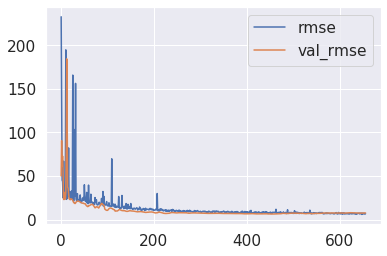

In [467]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mse']) * 30, np.sqrt(metrics['val_mse']) * 30)
plt.legend(['rmse', 'val_rmse'])
plt.show()

In [454]:
np.sqrt(model.evaluate(val_ds.batch(batch_size))) * 30

1/1 [==============================] - 0s 96ms/step - loss: 0.0443 - mse: 0.0443


array([6.31233895, 6.31233895])

In [455]:
np.sqrt(model.evaluate(test_ds.batch(batch_size))) * 30

1/1 [==============================] - 0s 95ms/step - loss: 0.0333 - mse: 0.0333


array([5.47284572, 5.47284572])

In [456]:
model.predict(get_data(train_files[0])[0]).mean() * 30

21.72100067138672

In [457]:
get_data(train_files[0])[1]

<tf.Tensor: shape=(), dtype=float64, numpy=0.8333333333333334>

In [458]:
meta = meta.assign(split = '', predict = -99.99, predict_group = 'cc')
for file in train_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean() * 30
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'train'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in test_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean() * 30
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'test'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in val_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean() * 30
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'val'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'

In [459]:
meta.predict.describe()

count    108.000000
mean      21.891159
std        1.360370
min       17.477626
25%       21.696025
50%       22.002001
75%       22.077500
max       28.506660
Name: predict, dtype: float64

In [460]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,6.316230
1,train,7.166761
2,val,7.098822


In [461]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,7.163739
1,male,6.857991


In [462]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict'] ))

7.029493057427161

In [463]:
meta.MMSE.describe()

count    108.000000
mean      23.092593
std        7.215685
min        1.000000
25%       17.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64

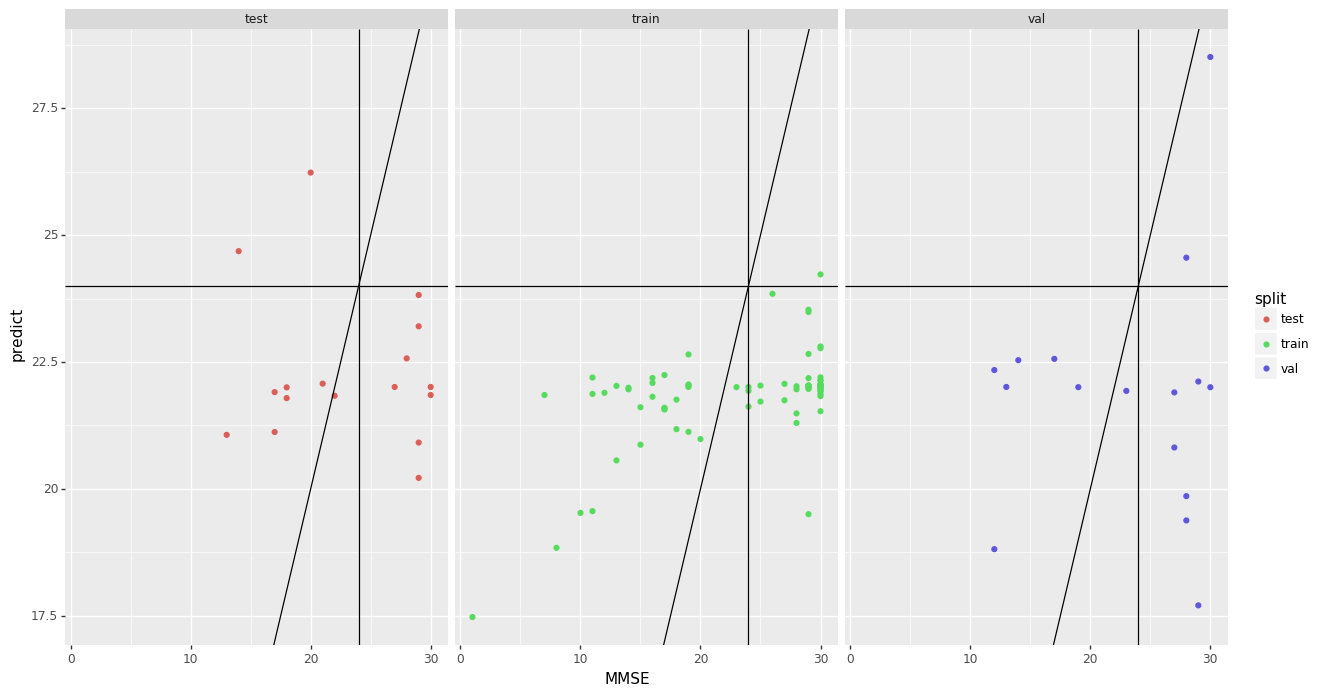

<ggplot: (8780854582213)>

In [464]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

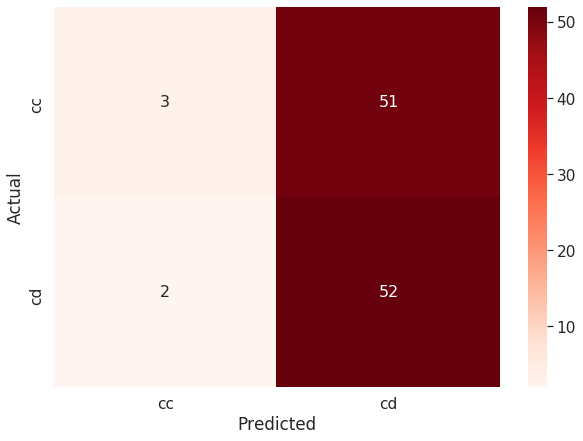

In [465]:
y_true = meta.Group
y_pred = meta.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [466]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          cc       0.60      0.06      0.10        54
          cd       0.50      0.96      0.66        54

    accuracy                           0.51       108
   macro avg       0.55      0.51      0.38       108
weighted avg       0.55      0.51      0.38       108



In [30]:
# model.save('saved_model/base_line/20210222')

INFO:tensorflow:Assets written to: saved_model/base_line/20210222/assets


In [29]:
ls saved_model/base_line

20210210/  20210217/  20210222/


# Pitts Corpus

In [287]:
data_path_pitt = '/tf/data/dementia/English/Pitt/'
files_pitt = tf.io.gfile.glob(data_path_pitt + 'Control/cookie/*.mp3') + \
             tf.io.gfile.glob(data_path_pitt + 'Dementia/cookie/*.mp3')

In [288]:
input_file = files_pitt[0]

In [291]:
input_file.split('.mp3')[0] + '.wav'

'/tf/data/dementia/English/Pitt/Control/cookie/128-3.wav'

In [292]:
def model_inference(filepath):

    import tensorflow as tf
    import numpy as np
    import json
    import requests	
    import os
    from datetime import datetime
    
    input_file = filepath
    if not filepath.lower().endswith(".wav"):
#         tmp_name = "tmp-"+datetime.now().strftime("%Y%m%d-%H%M%S")
        input_file = input_file.split('.mp3')[0] + '.wav'
        cmd = "ffmpeg -i " + filepath + " " + input_file
        os.system(cmd)
    
    audio_binary = tf.io.read_file(input_file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    if audio.shape[1] > 1:
        audio = tf.reshape(audio[:, 0], (audio.shape[0],1))

    waveform = tf.squeeze(audio, axis=-1)    
    rolling_waveform_tensors = window(waveform, size=_*30, stride=_*1)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
    rolling_spectrograms = rolling_spectrograms.numpy().tolist()
    
    predictions = model.predict(rolling_spectrograms)
    results = [x[0] for x in predictions]
    result = sum(results)/len(results) * 30

#     os.system('rm ' + input_file)
    return result, results

In [293]:
meta_pitt = pd.DataFrame(columns= ['file', 'ID', 'Group', 'MMSE', 'predict', 'predict_group', 'predicts'])
for file in tqdm(files_pitt):
    print(file)
    ID = file.split('/')[-1].split('.')[0]
    Group = file.split('/')[6]
    cha = pd.read_fwf(data_path_pitt + 'Pitt/' + Group + '/cookie/' + ID + '.cha')  
    cha_id = [x for x in cha['@UTF8'] if str.startswith(x, '@ID:')][0]
    
    if (cha_id.split('|')[-3] == ''):
        MMSE = np.NaN
    else:
        MMSE = int(cha_id.split('|')[-3])
        
    predict, predicts = model_inference(file)
    if (predict < 24):
        predict_group = 'Dementia'
    else:
        predict_group = 'Control'
    meta_pitt = meta_pitt.append(pd.DataFrame([[file, ID, Group, MMSE, predict, predict_group, predicts]], 
                                  columns = list(meta_pitt.columns)))




  0%|          | 0/552 [00:00<?, ?it/s]

/tf/data/dementia/English/Pitt/Control/cookie/128-3.mp3





  0%|          | 1/552 [00:06<59:33,  6.49s/it]

/tf/data/dementia/English/Pitt/Control/cookie/229-2.mp3





  0%|          | 2/552 [00:06<42:46,  4.67s/it]

/tf/data/dementia/English/Pitt/Control/cookie/196-0.mp3





  1%|          | 3/552 [00:08<34:19,  3.75s/it]

/tf/data/dementia/English/Pitt/Control/cookie/073-3.mp3





  1%|          | 4/552 [00:10<30:44,  3.37s/it]

/tf/data/dementia/English/Pitt/Control/cookie/668-0.mp3





  1%|          | 5/552 [00:12<26:23,  2.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-2.mp3





  1%|          | 6/552 [00:13<21:08,  2.32s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-2.mp3





  1%|▏         | 7/552 [00:14<17:42,  1.95s/it]

/tf/data/dementia/English/Pitt/Control/cookie/073-1.mp3





  1%|▏         | 8/552 [00:17<18:29,  2.04s/it]

/tf/data/dementia/English/Pitt/Control/cookie/296-2.mp3





  2%|▏         | 9/552 [00:20<21:14,  2.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-0.mp3





  2%|▏         | 10/552 [00:25<29:12,  3.23s/it]

/tf/data/dementia/English/Pitt/Control/cookie/167-2.mp3





  2%|▏         | 11/552 [00:26<23:32,  2.61s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-4.mp3





  2%|▏         | 12/552 [00:26<17:10,  1.91s/it]

/tf/data/dementia/English/Pitt/Control/cookie/002-1.mp3





  2%|▏         | 13/552 [00:29<18:02,  2.01s/it]

/tf/data/dementia/English/Pitt/Control/cookie/137-2.mp3





  3%|▎         | 14/552 [00:29<14:42,  1.64s/it]

/tf/data/dementia/English/Pitt/Control/cookie/302-0.mp3





  3%|▎         | 15/552 [00:30<12:50,  1.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/137-1.mp3





  3%|▎         | 16/552 [00:32<13:11,  1.48s/it]

/tf/data/dementia/English/Pitt/Control/cookie/141-0.mp3





  3%|▎         | 17/552 [00:32<10:39,  1.19s/it]

/tf/data/dementia/English/Pitt/Control/cookie/141-1.mp3





  3%|▎         | 18/552 [00:33<09:34,  1.08s/it]

/tf/data/dementia/English/Pitt/Control/cookie/266-0.mp3





  3%|▎         | 19/552 [00:34<08:58,  1.01s/it]

/tf/data/dementia/English/Pitt/Control/cookie/182-3.mp3





  4%|▎         | 20/552 [00:35<09:21,  1.06s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-2.mp3





  4%|▍         | 21/552 [00:36<07:40,  1.15it/s]

/tf/data/dementia/English/Pitt/Control/cookie/068-3.mp3





  4%|▍         | 22/552 [00:37<09:36,  1.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/155-0.mp3





  4%|▍         | 23/552 [00:39<12:12,  1.38s/it]

/tf/data/dementia/English/Pitt/Control/cookie/045-0.mp3





  4%|▍         | 24/552 [00:43<17:59,  2.04s/it]

/tf/data/dementia/English/Pitt/Control/cookie/052-0.mp3





  5%|▍         | 25/552 [00:44<16:12,  1.85s/it]

/tf/data/dementia/English/Pitt/Control/cookie/172-0.mp3





  5%|▍         | 26/552 [00:46<16:32,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/166-1.mp3





  5%|▍         | 27/552 [00:50<20:58,  2.40s/it]

/tf/data/dementia/English/Pitt/Control/cookie/068-2.mp3





  5%|▌         | 28/552 [00:51<18:11,  2.08s/it]

/tf/data/dementia/English/Pitt/Control/cookie/146-1.mp3





  5%|▌         | 29/552 [00:53<16:31,  1.90s/it]

/tf/data/dementia/English/Pitt/Control/cookie/242-0.mp3





  5%|▌         | 30/552 [00:55<16:27,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/691-0.mp3





  6%|▌         | 31/552 [00:57<17:17,  1.99s/it]

/tf/data/dementia/English/Pitt/Control/cookie/006-4.mp3





  6%|▌         | 32/552 [01:00<18:58,  2.19s/it]

/tf/data/dementia/English/Pitt/Control/cookie/211-1.mp3





  6%|▌         | 33/552 [01:02<20:21,  2.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/267-2.mp3





  6%|▌         | 34/552 [01:04<18:35,  2.15s/it]

/tf/data/dementia/English/Pitt/Control/cookie/113-1.mp3





  6%|▋         | 35/552 [01:05<16:35,  1.92s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-1.mp3





  7%|▋         | 36/552 [01:07<15:45,  1.83s/it]

/tf/data/dementia/English/Pitt/Control/cookie/155-3.mp3





  7%|▋         | 37/552 [01:08<13:43,  1.60s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-2.mp3





  7%|▋         | 38/552 [01:11<18:28,  2.16s/it]

/tf/data/dementia/English/Pitt/Control/cookie/096-1.mp3





  7%|▋         | 39/552 [01:13<18:05,  2.12s/it]

/tf/data/dementia/English/Pitt/Control/cookie/266-2.mp3





  7%|▋         | 40/552 [01:16<19:26,  2.28s/it]

/tf/data/dementia/English/Pitt/Control/cookie/056-4.mp3





  7%|▋         | 41/552 [01:17<15:26,  1.81s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-3.mp3





  8%|▊         | 42/552 [01:19<16:15,  1.91s/it]

/tf/data/dementia/English/Pitt/Control/cookie/304-2.mp3





  8%|▊         | 43/552 [01:20<14:50,  1.75s/it]

/tf/data/dementia/English/Pitt/Control/cookie/124-1.mp3





  8%|▊         | 44/552 [01:25<23:07,  2.73s/it]

/tf/data/dementia/English/Pitt/Control/cookie/209-1.mp3





  8%|▊         | 45/552 [01:26<18:23,  2.18s/it]

/tf/data/dementia/English/Pitt/Control/cookie/045-2.mp3





  8%|▊         | 46/552 [01:30<23:14,  2.76s/it]

/tf/data/dementia/English/Pitt/Control/cookie/296-0.mp3





  9%|▊         | 47/552 [01:32<20:22,  2.42s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-1.mp3





  9%|▊         | 48/552 [01:35<21:14,  2.53s/it]

/tf/data/dementia/English/Pitt/Control/cookie/209-2.mp3





  9%|▉         | 49/552 [01:37<19:06,  2.28s/it]

/tf/data/dementia/English/Pitt/Control/cookie/208-1.mp3





  9%|▉         | 50/552 [01:37<14:46,  1.77s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-3.mp3





  9%|▉         | 51/552 [01:40<17:29,  2.10s/it]

/tf/data/dementia/English/Pitt/Control/cookie/107-1.mp3





  9%|▉         | 52/552 [01:41<15:19,  1.84s/it]

/tf/data/dementia/English/Pitt/Control/cookie/130-3.mp3





 10%|▉         | 53/552 [01:42<11:44,  1.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/318-2.mp3





 10%|▉         | 54/552 [01:42<09:02,  1.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/227-0.mp3





 10%|▉         | 55/552 [01:44<10:43,  1.29s/it]

/tf/data/dementia/English/Pitt/Control/cookie/340-0.mp3





 10%|█         | 56/552 [01:45<10:22,  1.26s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-0.mp3





 10%|█         | 57/552 [01:46<10:03,  1.22s/it]

/tf/data/dementia/English/Pitt/Control/cookie/175-0.mp3





 11%|█         | 58/552 [01:48<12:27,  1.51s/it]

/tf/data/dementia/English/Pitt/Control/cookie/141-3.mp3





 11%|█         | 59/552 [01:49<11:33,  1.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/071-1.mp3





 11%|█         | 60/552 [01:50<09:14,  1.13s/it]

/tf/data/dementia/English/Pitt/Control/cookie/006-2.mp3





 11%|█         | 61/552 [01:51<08:57,  1.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/093-0.mp3





 11%|█         | 62/552 [01:52<09:08,  1.12s/it]

/tf/data/dementia/English/Pitt/Control/cookie/105-1.mp3





 11%|█▏        | 63/552 [01:54<10:02,  1.23s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-4.mp3





 12%|█▏        | 64/552 [01:55<11:23,  1.40s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-3.mp3





 12%|█▏        | 65/552 [01:56<10:32,  1.30s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-1.mp3





 12%|█▏        | 66/552 [02:00<16:13,  2.00s/it]

/tf/data/dementia/English/Pitt/Control/cookie/145-3.mp3





 12%|█▏        | 67/552 [02:03<17:49,  2.21s/it]

/tf/data/dementia/English/Pitt/Control/cookie/006-3.mp3





 12%|█▏        | 68/552 [02:04<16:16,  2.02s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-4.mp3





 12%|█▎        | 69/552 [02:07<18:01,  2.24s/it]

/tf/data/dementia/English/Pitt/Control/cookie/130-2.mp3





 13%|█▎        | 70/552 [02:08<13:51,  1.73s/it]

/tf/data/dementia/English/Pitt/Control/cookie/166-2.mp3





 13%|█▎        | 71/552 [02:09<13:23,  1.67s/it]

/tf/data/dementia/English/Pitt/Control/cookie/684-0.mp3





 13%|█▎        | 72/552 [02:13<17:47,  2.22s/it]

/tf/data/dementia/English/Pitt/Control/cookie/096-2.mp3





 13%|█▎        | 73/552 [02:14<15:49,  1.98s/it]

/tf/data/dementia/English/Pitt/Control/cookie/142-0.mp3





 13%|█▎        | 74/552 [02:16<15:37,  1.96s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-0.mp3





 14%|█▎        | 75/552 [02:17<13:02,  1.64s/it]

/tf/data/dementia/English/Pitt/Control/cookie/013-0.mp3





 14%|█▍        | 76/552 [02:18<12:40,  1.60s/it]

/tf/data/dementia/English/Pitt/Control/cookie/242-2.mp3





 14%|█▍        | 77/552 [02:22<16:22,  2.07s/it]

/tf/data/dementia/English/Pitt/Control/cookie/255-0.mp3





 14%|█▍        | 78/552 [02:23<14:05,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-2.mp3





 14%|█▍        | 79/552 [02:24<13:50,  1.76s/it]

/tf/data/dementia/English/Pitt/Control/cookie/175-2.mp3





 14%|█▍        | 80/552 [02:26<13:17,  1.69s/it]

/tf/data/dementia/English/Pitt/Control/cookie/068-0.mp3





 15%|█▍        | 81/552 [02:28<13:46,  1.75s/it]

/tf/data/dementia/English/Pitt/Control/cookie/142-1.mp3





 15%|█▍        | 82/552 [02:29<12:34,  1.61s/it]

/tf/data/dementia/English/Pitt/Control/cookie/105-0.mp3





 15%|█▌        | 83/552 [02:31<14:03,  1.80s/it]

/tf/data/dementia/English/Pitt/Control/cookie/013-2.mp3





 15%|█▌        | 84/552 [02:33<12:57,  1.66s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-0.mp3





 15%|█▌        | 85/552 [02:37<18:45,  2.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/132-0.mp3





 16%|█▌        | 86/552 [02:38<16:36,  2.14s/it]

/tf/data/dementia/English/Pitt/Control/cookie/274-0.mp3





 16%|█▌        | 87/552 [02:40<14:26,  1.86s/it]

/tf/data/dementia/English/Pitt/Control/cookie/248-2.mp3





 16%|█▌        | 88/552 [02:40<12:06,  1.57s/it]

/tf/data/dementia/English/Pitt/Control/cookie/128-2.mp3





 16%|█▌        | 89/552 [02:45<19:19,  2.50s/it]

/tf/data/dementia/English/Pitt/Control/cookie/686-0.mp3





 16%|█▋        | 90/552 [02:47<18:48,  2.44s/it]

/tf/data/dementia/English/Pitt/Control/cookie/225-0.mp3





 16%|█▋        | 91/552 [02:51<22:07,  2.88s/it]

/tf/data/dementia/English/Pitt/Control/cookie/155-2.mp3





 17%|█▋        | 92/552 [02:54<22:46,  2.97s/it]

/tf/data/dementia/English/Pitt/Control/cookie/248-1.mp3





 17%|█▋        | 93/552 [02:57<21:38,  2.83s/it]

/tf/data/dementia/English/Pitt/Control/cookie/042-3.mp3





 17%|█▋        | 94/552 [02:58<17:51,  2.34s/it]

/tf/data/dementia/English/Pitt/Control/cookie/256-1.mp3





 17%|█▋        | 95/552 [02:59<14:25,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/109-3.mp3





 17%|█▋        | 96/552 [03:00<13:20,  1.75s/it]

/tf/data/dementia/English/Pitt/Control/cookie/175-1.mp3





 18%|█▊        | 97/552 [03:02<13:59,  1.84s/it]

/tf/data/dementia/English/Pitt/Control/cookie/092-1.mp3





 18%|█▊        | 98/552 [03:04<13:19,  1.76s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-0.mp3





 18%|█▊        | 99/552 [03:05<10:37,  1.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/678-0.mp3





 18%|█▊        | 100/552 [03:07<13:53,  1.84s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-1.mp3





 18%|█▊        | 101/552 [03:11<16:46,  2.23s/it]

/tf/data/dementia/English/Pitt/Control/cookie/227-1.mp3





 18%|█▊        | 102/552 [03:13<16:16,  2.17s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-3.mp3





 19%|█▊        | 103/552 [03:15<17:43,  2.37s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-4.mp3





 19%|█▉        | 104/552 [03:19<19:40,  2.63s/it]

/tf/data/dementia/English/Pitt/Control/cookie/210-1.mp3





 19%|█▉        | 105/552 [03:22<20:13,  2.71s/it]

/tf/data/dementia/English/Pitt/Control/cookie/208-0.mp3





 19%|█▉        | 106/552 [03:23<17:48,  2.40s/it]

/tf/data/dementia/English/Pitt/Control/cookie/002-2.mp3





 19%|█▉        | 107/552 [03:26<17:59,  2.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/129-1.mp3





 20%|█▉        | 108/552 [03:28<17:51,  2.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/150-1.mp3





 20%|█▉        | 109/552 [03:30<16:25,  2.22s/it]

/tf/data/dementia/English/Pitt/Control/cookie/073-0.mp3





 20%|█▉        | 110/552 [03:33<17:15,  2.34s/it]

/tf/data/dementia/English/Pitt/Control/cookie/298-1.mp3





 20%|██        | 111/552 [03:33<13:50,  1.88s/it]

/tf/data/dementia/English/Pitt/Control/cookie/688-0.mp3





 20%|██        | 112/552 [03:35<12:47,  1.74s/it]

/tf/data/dementia/English/Pitt/Control/cookie/210-2.mp3





 20%|██        | 113/552 [03:39<17:11,  2.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/709-2.mp3





 21%|██        | 114/552 [03:40<15:54,  2.18s/it]

/tf/data/dementia/English/Pitt/Control/cookie/211-2.mp3





 21%|██        | 115/552 [03:43<17:03,  2.34s/it]

/tf/data/dementia/English/Pitt/Control/cookie/322-1.mp3





 21%|██        | 116/552 [03:45<16:01,  2.21s/it]

/tf/data/dementia/English/Pitt/Control/cookie/171-0.mp3





 21%|██        | 117/552 [03:46<12:54,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/130-1.mp3





 21%|██▏       | 118/552 [03:46<09:38,  1.33s/it]

/tf/data/dementia/English/Pitt/Control/cookie/166-0.mp3





 22%|██▏       | 119/552 [03:47<08:05,  1.12s/it]

/tf/data/dementia/English/Pitt/Control/cookie/137-0.mp3





 22%|██▏       | 120/552 [03:50<12:59,  1.80s/it]

/tf/data/dementia/English/Pitt/Control/cookie/140-3.mp3





 22%|██▏       | 121/552 [03:51<12:05,  1.68s/it]

/tf/data/dementia/English/Pitt/Control/cookie/243-1.mp3





 22%|██▏       | 122/552 [03:54<14:41,  2.05s/it]

/tf/data/dementia/English/Pitt/Control/cookie/158-2.mp3





 22%|██▏       | 123/552 [03:55<12:26,  1.74s/it]

/tf/data/dementia/English/Pitt/Control/cookie/175-3.mp3





 22%|██▏       | 124/552 [03:57<11:21,  1.59s/it]

/tf/data/dementia/English/Pitt/Control/cookie/113-2.mp3





 23%|██▎       | 125/552 [03:58<11:18,  1.59s/it]

/tf/data/dementia/English/Pitt/Control/cookie/022-1.mp3





 23%|██▎       | 126/552 [03:59<10:12,  1.44s/it]

/tf/data/dementia/English/Pitt/Control/cookie/056-3.mp3





 23%|██▎       | 127/552 [04:00<09:22,  1.32s/it]

/tf/data/dementia/English/Pitt/Control/cookie/292-1.mp3





 23%|██▎       | 128/552 [04:02<09:53,  1.40s/it]

/tf/data/dementia/English/Pitt/Control/cookie/318-0.mp3





 23%|██▎       | 129/552 [04:04<11:05,  1.57s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-3.mp3





 24%|██▎       | 130/552 [04:04<08:39,  1.23s/it]

/tf/data/dementia/English/Pitt/Control/cookie/167-3.mp3





 24%|██▎       | 131/552 [04:07<12:33,  1.79s/it]

/tf/data/dementia/English/Pitt/Control/cookie/059-2.mp3





 24%|██▍       | 132/552 [04:08<10:57,  1.57s/it]

/tf/data/dementia/English/Pitt/Control/cookie/171-1.mp3





 24%|██▍       | 133/552 [04:09<08:27,  1.21s/it]

/tf/data/dementia/English/Pitt/Control/cookie/054-0.mp3





 24%|██▍       | 134/552 [04:11<10:57,  1.57s/it]

/tf/data/dementia/English/Pitt/Control/cookie/139-1.mp3





 24%|██▍       | 135/552 [04:12<09:19,  1.34s/it]

/tf/data/dementia/English/Pitt/Control/cookie/138-3.mp3





 25%|██▍       | 136/552 [04:14<09:45,  1.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/280-1.mp3





 25%|██▍       | 137/552 [04:14<07:23,  1.07s/it]

/tf/data/dementia/English/Pitt/Control/cookie/145-1.mp3





 25%|██▌       | 138/552 [04:15<07:51,  1.14s/it]

/tf/data/dementia/English/Pitt/Control/cookie/323-1.mp3





 25%|██▌       | 139/552 [04:18<10:30,  1.53s/it]

/tf/data/dementia/English/Pitt/Control/cookie/045-3.mp3





 25%|██▌       | 140/552 [04:20<12:23,  1.80s/it]

/tf/data/dementia/English/Pitt/Control/cookie/109-1.mp3





 26%|██▌       | 141/552 [04:22<13:16,  1.94s/it]

/tf/data/dementia/English/Pitt/Control/cookie/105-2.mp3





 26%|██▌       | 142/552 [04:26<16:04,  2.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/336-1.mp3





 26%|██▌       | 143/552 [04:28<15:49,  2.32s/it]

/tf/data/dementia/English/Pitt/Control/cookie/052-2.mp3





 26%|██▌       | 144/552 [04:28<11:36,  1.71s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-4.mp3





 26%|██▋       | 145/552 [04:31<13:11,  1.95s/it]

/tf/data/dementia/English/Pitt/Control/cookie/229-1.mp3





 26%|██▋       | 146/552 [04:31<10:26,  1.54s/it]

/tf/data/dementia/English/Pitt/Control/cookie/140-0.mp3





 27%|██▋       | 147/552 [04:34<12:47,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/109-4.mp3





 27%|██▋       | 148/552 [04:36<12:14,  1.82s/it]

/tf/data/dementia/English/Pitt/Control/cookie/323-0.mp3





 27%|██▋       | 149/552 [04:39<15:04,  2.25s/it]

/tf/data/dementia/English/Pitt/Control/cookie/297-1.mp3





 27%|██▋       | 150/552 [04:40<11:50,  1.77s/it]

/tf/data/dementia/English/Pitt/Control/cookie/192-2.mp3





 27%|██▋       | 151/552 [04:41<12:05,  1.81s/it]

/tf/data/dementia/English/Pitt/Control/cookie/092-0.mp3





 28%|██▊       | 152/552 [04:42<10:01,  1.50s/it]

/tf/data/dementia/English/Pitt/Control/cookie/142-3.mp3





 28%|██▊       | 153/552 [04:43<09:17,  1.40s/it]

/tf/data/dementia/English/Pitt/Control/cookie/280-0.mp3





 28%|██▊       | 154/552 [04:46<11:25,  1.72s/it]

/tf/data/dementia/English/Pitt/Control/cookie/275-1.mp3





 28%|██▊       | 155/552 [04:47<10:12,  1.54s/it]

/tf/data/dementia/English/Pitt/Control/cookie/124-0.mp3





 28%|██▊       | 156/552 [04:49<11:43,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/256-2.mp3





 28%|██▊       | 157/552 [04:51<12:16,  1.87s/it]

/tf/data/dementia/English/Pitt/Control/cookie/042-1.mp3





 29%|██▊       | 158/552 [04:53<12:07,  1.85s/it]

/tf/data/dementia/English/Pitt/Control/cookie/022-0.mp3





 29%|██▉       | 159/552 [04:55<11:38,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/266-1.mp3





 29%|██▉       | 160/552 [04:56<09:58,  1.53s/it]

/tf/data/dementia/English/Pitt/Control/cookie/002-0.mp3





 29%|██▉       | 161/552 [04:57<10:16,  1.58s/it]

/tf/data/dementia/English/Pitt/Control/cookie/092-3.mp3





 29%|██▉       | 162/552 [04:58<07:40,  1.18s/it]

/tf/data/dementia/English/Pitt/Control/cookie/332-0.mp3





 30%|██▉       | 163/552 [04:58<06:22,  1.02it/s]

/tf/data/dementia/English/Pitt/Control/cookie/042-4.mp3





 30%|██▉       | 164/552 [04:59<05:25,  1.19it/s]

/tf/data/dementia/English/Pitt/Control/cookie/042-2.mp3





 30%|██▉       | 165/552 [05:00<06:13,  1.04it/s]

/tf/data/dementia/English/Pitt/Control/cookie/071-4.mp3





 30%|███       | 166/552 [05:00<05:10,  1.24it/s]

/tf/data/dementia/English/Pitt/Control/cookie/322-2.mp3





 30%|███       | 167/552 [05:01<04:38,  1.38it/s]

/tf/data/dementia/English/Pitt/Control/cookie/297-2.mp3





 30%|███       | 168/552 [05:03<06:24,  1.00s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-4.mp3





 31%|███       | 169/552 [05:03<05:48,  1.10it/s]

/tf/data/dementia/English/Pitt/Control/cookie/296-1.mp3





 31%|███       | 170/552 [05:06<09:35,  1.51s/it]

/tf/data/dementia/English/Pitt/Control/cookie/022-2.mp3





 31%|███       | 171/552 [05:08<09:13,  1.45s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-2.mp3





 31%|███       | 172/552 [05:11<12:54,  2.04s/it]

/tf/data/dementia/English/Pitt/Control/cookie/113-0.mp3





 31%|███▏      | 173/552 [05:12<10:42,  1.70s/it]

/tf/data/dementia/English/Pitt/Control/cookie/274-2.mp3





 32%|███▏      | 174/552 [05:12<08:34,  1.36s/it]

/tf/data/dementia/English/Pitt/Control/cookie/631-0.mp3





 32%|███▏      | 175/552 [05:13<06:51,  1.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-3.mp3





 32%|███▏      | 176/552 [05:14<07:31,  1.20s/it]

/tf/data/dementia/English/Pitt/Control/cookie/139-0.mp3





 32%|███▏      | 177/552 [05:17<10:00,  1.60s/it]

/tf/data/dementia/English/Pitt/Control/cookie/071-2.mp3





 32%|███▏      | 178/552 [05:18<09:21,  1.50s/it]

/tf/data/dementia/English/Pitt/Control/cookie/158-3.mp3





 32%|███▏      | 179/552 [05:19<09:01,  1.45s/it]

/tf/data/dementia/English/Pitt/Control/cookie/243-0.mp3





 33%|███▎      | 180/552 [05:24<15:32,  2.51s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-2.mp3





 33%|███▎      | 181/552 [05:25<12:40,  2.05s/it]

/tf/data/dementia/English/Pitt/Control/cookie/158-0.mp3





 33%|███▎      | 182/552 [05:27<11:58,  1.94s/it]

/tf/data/dementia/English/Pitt/Control/cookie/128-1.mp3





 33%|███▎      | 183/552 [05:30<14:13,  2.31s/it]

/tf/data/dementia/English/Pitt/Control/cookie/709-0.mp3





 33%|███▎      | 184/552 [05:31<11:38,  1.90s/it]

/tf/data/dementia/English/Pitt/Control/cookie/092-2.mp3





 34%|███▎      | 185/552 [05:32<09:07,  1.49s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-3.mp3





 34%|███▎      | 186/552 [05:33<08:37,  1.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/138-1.mp3





 34%|███▍      | 187/552 [05:35<10:28,  1.72s/it]

/tf/data/dementia/English/Pitt/Control/cookie/056-0.mp3





 34%|███▍      | 188/552 [05:36<08:25,  1.39s/it]

/tf/data/dementia/English/Pitt/Control/cookie/055-0.mp3





 34%|███▍      | 189/552 [05:38<08:52,  1.47s/it]

/tf/data/dementia/English/Pitt/Control/cookie/167-1.mp3





 34%|███▍      | 190/552 [05:39<07:54,  1.31s/it]

/tf/data/dementia/English/Pitt/Control/cookie/113-3.mp3





 35%|███▍      | 191/552 [05:40<07:22,  1.23s/it]

/tf/data/dementia/English/Pitt/Control/cookie/275-0.mp3





 35%|███▍      | 192/552 [05:42<08:48,  1.47s/it]

/tf/data/dementia/English/Pitt/Control/cookie/245-2.mp3





 35%|███▍      | 193/552 [05:44<10:37,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/150-2.mp3





 35%|███▌      | 194/552 [05:46<10:59,  1.84s/it]

/tf/data/dementia/English/Pitt/Control/cookie/232-1.mp3





 35%|███▌      | 195/552 [05:49<12:06,  2.04s/it]

/tf/data/dementia/English/Pitt/Control/cookie/013-3.mp3





 36%|███▌      | 196/552 [05:50<11:21,  1.91s/it]

/tf/data/dementia/English/Pitt/Control/cookie/256-0.mp3





 36%|███▌      | 197/552 [05:52<11:09,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/267-0.mp3





 36%|███▌      | 198/552 [05:53<10:01,  1.70s/it]

/tf/data/dementia/English/Pitt/Control/cookie/107-2.mp3





 36%|███▌      | 199/552 [05:54<07:54,  1.34s/it]

/tf/data/dementia/English/Pitt/Control/cookie/208-2.mp3





 36%|███▌      | 200/552 [05:56<09:30,  1.62s/it]

/tf/data/dementia/English/Pitt/Control/cookie/280-2.mp3





 36%|███▋      | 201/552 [05:57<08:54,  1.52s/it]

/tf/data/dementia/English/Pitt/Control/cookie/232-0.mp3





 37%|███▋      | 202/552 [06:00<10:39,  1.83s/it]

/tf/data/dementia/English/Pitt/Control/cookie/192-0.mp3





 37%|███▋      | 203/552 [06:01<08:59,  1.55s/it]

/tf/data/dementia/English/Pitt/Control/cookie/242-1.mp3





 37%|███▋      | 204/552 [06:03<10:24,  1.79s/it]

/tf/data/dementia/English/Pitt/Control/cookie/158-1.mp3





 37%|███▋      | 205/552 [06:05<11:00,  1.90s/it]

/tf/data/dementia/English/Pitt/Control/cookie/295-1.mp3





 37%|███▋      | 206/552 [06:06<08:10,  1.42s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-1.mp3





 38%|███▊      | 207/552 [06:07<08:44,  1.52s/it]

/tf/data/dementia/English/Pitt/Control/cookie/248-0.mp3





 38%|███▊      | 208/552 [06:10<10:06,  1.76s/it]

/tf/data/dementia/English/Pitt/Control/cookie/225-2.mp3





 38%|███▊      | 209/552 [06:15<15:42,  2.75s/it]

/tf/data/dementia/English/Pitt/Control/cookie/059-4.mp3





 38%|███▊      | 210/552 [06:15<11:44,  2.06s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-1.mp3





 38%|███▊      | 211/552 [06:17<11:14,  1.98s/it]

/tf/data/dementia/English/Pitt/Control/cookie/013-4.mp3





 38%|███▊      | 212/552 [06:18<09:49,  1.73s/it]

/tf/data/dementia/English/Pitt/Control/cookie/304-1.mp3





 39%|███▊      | 213/552 [06:19<07:17,  1.29s/it]

/tf/data/dementia/English/Pitt/Control/cookie/139-3.mp3





 39%|███▉      | 214/552 [06:19<05:54,  1.05s/it]

/tf/data/dementia/English/Pitt/Control/cookie/295-0.mp3





 39%|███▉      | 215/552 [06:19<04:35,  1.22it/s]

/tf/data/dementia/English/Pitt/Control/cookie/661-0.mp3





 39%|███▉      | 216/552 [06:21<06:01,  1.08s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-1.mp3





 39%|███▉      | 217/552 [06:23<06:57,  1.24s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-4.mp3





 39%|███▉      | 218/552 [06:26<09:48,  1.76s/it]

/tf/data/dementia/English/Pitt/Control/cookie/245-1.mp3





 40%|███▉      | 219/552 [06:28<11:31,  2.08s/it]

/tf/data/dementia/English/Pitt/Control/cookie/627-0.mp3





 40%|███▉      | 220/552 [06:30<09:55,  1.79s/it]

/tf/data/dementia/English/Pitt/Control/cookie/612-0.mp3





 40%|████      | 221/552 [06:32<11:19,  2.05s/it]

/tf/data/dementia/English/Pitt/Control/cookie/141-2.mp3





 40%|████      | 222/552 [06:34<10:24,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-0.mp3





 40%|████      | 223/552 [06:37<12:29,  2.28s/it]

/tf/data/dementia/English/Pitt/Control/cookie/196-1.mp3





 41%|████      | 224/552 [06:39<11:58,  2.19s/it]

/tf/data/dementia/English/Pitt/Control/cookie/209-3.mp3





 41%|████      | 225/552 [06:43<15:48,  2.90s/it]

/tf/data/dementia/English/Pitt/Control/cookie/028-4.mp3





 41%|████      | 226/552 [06:46<14:34,  2.68s/it]

/tf/data/dementia/English/Pitt/Control/cookie/132-1.mp3





 41%|████      | 227/552 [06:47<13:16,  2.45s/it]

/tf/data/dementia/English/Pitt/Control/cookie/299-1.mp3





 41%|████▏     | 228/552 [06:48<10:16,  1.90s/it]

/tf/data/dementia/English/Pitt/Control/cookie/002-3.mp3





 41%|████▏     | 229/552 [06:52<13:00,  2.42s/it]

/tf/data/dementia/English/Pitt/Control/cookie/318-1.mp3





 42%|████▏     | 230/552 [06:53<10:37,  1.98s/it]

/tf/data/dementia/English/Pitt/Control/cookie/071-0.mp3





 42%|████▏     | 231/552 [06:54<09:12,  1.72s/it]

/tf/data/dementia/English/Pitt/Control/cookie/150-0.mp3





 42%|████▏     | 232/552 [06:55<07:49,  1.47s/it]

/tf/data/dementia/English/Pitt/Control/cookie/245-0.mp3





 42%|████▏     | 233/552 [06:56<07:36,  1.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/137-3.mp3





 42%|████▏     | 234/552 [06:58<08:45,  1.65s/it]

/tf/data/dementia/English/Pitt/Control/cookie/017-4.mp3





 43%|████▎     | 235/552 [07:02<11:44,  2.22s/it]

/tf/data/dementia/English/Pitt/Control/cookie/028-1.mp3





 43%|████▎     | 236/552 [07:04<11:39,  2.21s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-0.mp3





 43%|████▎     | 237/552 [07:08<14:22,  2.74s/it]

/tf/data/dementia/English/Pitt/Control/cookie/255-1.mp3





 43%|████▎     | 238/552 [07:09<11:14,  2.15s/it]

/tf/data/dementia/English/Pitt/Control/cookie/274-1.mp3





 43%|████▎     | 239/552 [07:10<09:09,  1.75s/it]

/tf/data/dementia/English/Pitt/Control/cookie/143-3.mp3





 43%|████▎     | 240/552 [07:10<07:01,  1.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/071-3.mp3





 44%|████▎     | 241/552 [07:12<07:32,  1.45s/it]

/tf/data/dementia/English/Pitt/Control/cookie/059-3.mp3





 44%|████▍     | 242/552 [07:12<06:32,  1.27s/it]

/tf/data/dementia/English/Pitt/Control/cookie/093-1.mp3





 44%|████▍     | 243/552 [07:13<05:00,  1.03it/s]

/tf/data/dementia/English/Pitt/Dementia/cookie/563-0.mp3





 44%|████▍     | 244/552 [07:15<07:21,  1.43s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/076-4.mp3





 44%|████▍     | 245/552 [07:17<07:35,  1.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/341-0.mp3





 45%|████▍     | 246/552 [07:19<08:27,  1.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/164-3.mp3





 45%|████▍     | 247/552 [07:20<08:02,  1.58s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/585-0.mp3





 45%|████▍     | 248/552 [07:23<09:43,  1.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/695-0.mp3





 45%|████▌     | 249/552 [07:25<09:41,  1.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/381-1.mp3





 45%|████▌     | 250/552 [07:26<09:02,  1.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/504-0.mp3





 45%|████▌     | 251/552 [07:28<08:05,  1.61s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/689-0.mp3





 46%|████▌     | 252/552 [07:29<07:41,  1.54s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/252-2.mp3





 46%|████▌     | 253/552 [07:30<07:03,  1.42s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/252-0.mp3





 46%|████▌     | 254/552 [07:32<08:00,  1.61s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/244-0.mp3





 46%|████▌     | 255/552 [07:40<16:41,  3.37s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/058-4.mp3





 46%|████▋     | 256/552 [07:41<13:47,  2.79s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/672-0.mp3





 47%|████▋     | 257/552 [07:42<10:43,  2.18s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/234-0.mp3





 47%|████▋     | 258/552 [07:42<07:55,  1.62s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/067-2.mp3





 47%|████▋     | 259/552 [07:45<09:12,  1.89s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/601-0.mp3





 47%|████▋     | 260/552 [07:45<07:26,  1.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/282-0.mp3





 47%|████▋     | 261/552 [07:48<08:40,  1.79s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/223-1.mp3





 47%|████▋     | 262/552 [07:51<11:13,  2.32s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-4.mp3





 48%|████▊     | 263/552 [07:53<10:42,  2.22s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/016-3.mp3





 48%|████▊     | 264/552 [07:54<08:09,  1.70s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/714-0.mp3





 48%|████▊     | 265/552 [07:56<09:31,  1.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/350-0.mp3





 48%|████▊     | 266/552 [07:59<10:53,  2.28s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/279-1.mp3





 48%|████▊     | 267/552 [08:00<08:01,  1.69s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/663-0.mp3





 49%|████▊     | 268/552 [08:00<05:59,  1.27s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/450-1.mp3





 49%|████▊     | 269/552 [08:02<06:57,  1.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/078-0.mp3





 49%|████▉     | 270/552 [08:05<08:39,  1.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/238-0.mp3





 49%|████▉     | 271/552 [08:10<12:52,  2.75s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/122-1.mp3





 49%|████▉     | 272/552 [08:15<16:49,  3.60s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/650-0.mp3





 49%|████▉     | 273/552 [08:19<16:54,  3.64s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/183-2.mp3





 50%|████▉     | 274/552 [08:20<13:34,  2.93s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/551-0.mp3





 50%|████▉     | 275/552 [08:23<12:59,  2.81s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/205-1.mp3





 50%|█████     | 276/552 [08:27<15:19,  3.33s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/270-1.mp3





 50%|█████     | 277/552 [08:29<12:51,  2.81s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/310-0.mp3





 50%|█████     | 278/552 [08:31<12:35,  2.76s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/023-0.mp3





 51%|█████     | 279/552 [08:35<13:49,  3.04s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/057-0.mp3





 51%|█████     | 280/552 [08:38<13:04,  2.88s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/157-2.mp3





 51%|█████     | 281/552 [08:38<09:57,  2.20s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/051-3.mp3





 51%|█████     | 282/552 [08:42<12:10,  2.71s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/001-2.mp3





 51%|█████▏    | 283/552 [08:45<11:59,  2.68s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/493-0.mp3





 51%|█████▏    | 284/552 [08:47<11:43,  2.62s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/651-0.mp3





 52%|█████▏    | 285/552 [08:51<12:39,  2.85s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/325-1.mp3





 52%|█████▏    | 286/552 [08:52<10:00,  2.26s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/639-0.mp3





 52%|█████▏    | 287/552 [08:53<09:21,  2.12s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/035-1.mp3





 52%|█████▏    | 288/552 [08:56<09:47,  2.23s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/029-1.mp3





 52%|█████▏    | 289/552 [09:01<13:27,  3.07s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/339-0.mp3





 53%|█████▎    | 290/552 [09:02<10:46,  2.47s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/357-0.mp3





 53%|█████▎    | 291/552 [09:04<10:24,  2.39s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/270-0.mp3





 53%|█████▎    | 292/552 [09:07<10:57,  2.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/579-0.mp3





 53%|█████▎    | 293/552 [09:08<08:46,  2.03s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/235-2.mp3





 53%|█████▎    | 294/552 [09:11<09:46,  2.27s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/087-1.mp3





 53%|█████▎    | 295/552 [09:13<09:50,  2.30s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/528-0.mp3





 54%|█████▎    | 296/552 [09:14<07:59,  1.87s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/511-0.mp3





 54%|█████▍    | 297/552 [09:16<08:30,  2.00s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/216-0.mp3





 54%|█████▍    | 298/552 [09:17<06:25,  1.52s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/368-0.mp3





 54%|█████▍    | 299/552 [09:18<06:08,  1.46s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/058-1.mp3





 54%|█████▍    | 300/552 [09:22<08:49,  2.10s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/350-1.mp3





 55%|█████▍    | 301/552 [09:25<10:13,  2.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/269-0.mp3





 55%|█████▍    | 302/552 [09:30<13:56,  3.35s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/181-3.mp3





 55%|█████▍    | 303/552 [09:32<12:17,  2.96s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/466-0.mp3





 55%|█████▌    | 304/552 [09:34<11:15,  2.72s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/497-1.mp3





 55%|█████▌    | 305/552 [09:36<09:39,  2.35s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/220-0.mp3





 55%|█████▌    | 306/552 [09:38<09:14,  2.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/283-0.mp3





 56%|█████▌    | 307/552 [09:39<08:11,  2.01s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/702-0.mp3





 56%|█████▌    | 308/552 [09:40<06:32,  1.61s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/016-4.mp3





 56%|█████▌    | 309/552 [09:43<07:40,  1.89s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/168-1.mp3





 56%|█████▌    | 310/552 [09:45<08:39,  2.15s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/609-0.mp3





 56%|█████▋    | 311/552 [09:49<10:45,  2.68s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/172-3.mp3





 57%|█████▋    | 312/552 [09:50<08:05,  2.02s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/642-0.mp3





 57%|█████▋    | 313/552 [09:51<07:15,  1.82s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/581-0.mp3





 57%|█████▋    | 314/552 [09:54<08:08,  2.05s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/181-0.mp3





 57%|█████▋    | 315/552 [09:56<08:10,  2.07s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-1.mp3





 57%|█████▋    | 316/552 [09:58<08:26,  2.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/057-2.mp3





 57%|█████▋    | 317/552 [10:03<11:06,  2.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/125-0.mp3





 58%|█████▊    | 318/552 [10:08<14:02,  3.60s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/065-0.mp3





 58%|█████▊    | 319/552 [10:10<12:33,  3.23s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/291-2.mp3





 58%|█████▊    | 320/552 [10:12<10:15,  2.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/508-1.mp3





 58%|█████▊    | 321/552 [10:13<09:03,  2.35s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/212-2.mp3





 58%|█████▊    | 322/552 [10:17<11:00,  2.87s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/181-1.mp3





 59%|█████▊    | 323/552 [10:20<10:37,  2.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/184-1.mp3





 59%|█████▊    | 324/552 [10:23<11:22,  2.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/094-2.mp3





 59%|█████▉    | 325/552 [10:27<11:44,  3.10s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/168-0.mp3





 59%|█████▉    | 326/552 [10:27<08:38,  2.30s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/218-0.mp3





 59%|█████▉    | 327/552 [10:31<10:22,  2.76s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/587-0.mp3





 59%|█████▉    | 328/552 [10:33<09:25,  2.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/122-0.mp3





 60%|█████▉    | 329/552 [10:35<09:06,  2.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/360-0.mp3





 60%|█████▉    | 330/552 [10:36<07:18,  1.98s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/203-1.mp3





 60%|█████▉    | 331/552 [10:41<10:01,  2.72s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/595-0.mp3





 60%|██████    | 332/552 [10:42<08:32,  2.33s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/325-0.mp3





 60%|██████    | 333/552 [10:44<07:52,  2.16s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/676-0.mp3





 61%|██████    | 334/552 [10:44<05:49,  1.60s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/051-0.mp3





 61%|██████    | 335/552 [10:45<05:29,  1.52s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/471-0.mp3





 61%|██████    | 336/552 [10:46<04:39,  1.30s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/355-0.mp3





 61%|██████    | 337/552 [10:47<04:01,  1.12s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/270-2.mp3





 61%|██████    | 338/552 [10:50<05:53,  1.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/016-1.mp3





 61%|██████▏   | 339/552 [10:51<05:18,  1.49s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/094-3.mp3





 62%|██████▏   | 340/552 [10:53<06:13,  1.76s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/237-2.mp3





 62%|██████▏   | 341/552 [10:56<07:06,  2.02s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/493-1.mp3





 62%|██████▏   | 342/552 [10:58<07:16,  2.08s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/282-2.mp3





 62%|██████▏   | 343/552 [11:00<07:03,  2.03s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/024-2.mp3





 62%|██████▏   | 344/552 [11:03<07:53,  2.28s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/223-0.mp3





 62%|██████▎   | 345/552 [11:06<09:02,  2.62s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/076-2.mp3





 63%|██████▎   | 346/552 [11:10<09:44,  2.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/472-0.mp3





 63%|██████▎   | 347/552 [11:13<09:44,  2.85s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-2.mp3





 63%|██████▎   | 348/552 [11:15<08:43,  2.57s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/035-0.mp3





 63%|██████▎   | 349/552 [11:17<08:23,  2.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/046-0.mp3





 63%|██████▎   | 350/552 [11:19<07:35,  2.26s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/014-2.mp3





 64%|██████▎   | 351/552 [11:23<09:57,  2.97s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/607-0.mp3





 64%|██████▍   | 352/552 [11:25<08:27,  2.54s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/039-0.mp3





 64%|██████▍   | 353/552 [11:27<08:03,  2.43s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/062-0.mp3





 64%|██████▍   | 354/552 [11:29<07:50,  2.37s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/078-1.mp3





 64%|██████▍   | 355/552 [11:32<08:11,  2.50s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/269-1.mp3





 64%|██████▍   | 356/552 [11:36<09:27,  2.90s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/337-0.mp3





 65%|██████▍   | 357/552 [11:37<07:52,  2.42s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/640-0.mp3





 65%|██████▍   | 358/552 [11:37<05:46,  1.79s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/343-0.mp3





 65%|██████▌   | 359/552 [11:39<05:52,  1.83s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-2.mp3





 65%|██████▌   | 360/552 [11:40<05:12,  1.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/573-0.mp3





 65%|██████▌   | 361/552 [11:42<05:03,  1.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/062-3.mp3





 66%|██████▌   | 362/552 [11:43<04:41,  1.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/212-1.mp3





 66%|██████▌   | 363/552 [11:45<04:42,  1.50s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/578-0.mp3





 66%|██████▌   | 364/552 [11:47<05:44,  1.83s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/237-1.mp3





 66%|██████▌   | 365/552 [11:49<05:54,  1.90s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/184-2.mp3





 66%|██████▋   | 366/552 [11:51<05:49,  1.88s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/544-1.mp3





 66%|██████▋   | 367/552 [11:51<04:18,  1.40s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/183-3.mp3





 67%|██████▋   | 368/552 [11:53<04:12,  1.37s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-0.mp3





 67%|██████▋   | 369/552 [11:54<04:17,  1.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/235-0.mp3





 67%|██████▋   | 370/552 [12:01<08:57,  2.95s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/488-1.mp3





 67%|██████▋   | 371/552 [12:01<06:36,  2.19s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/291-1.mp3





 67%|██████▋   | 372/552 [12:02<05:12,  1.73s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/559-0.mp3





 68%|██████▊   | 373/552 [12:03<04:52,  1.64s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/306-0.mp3





 68%|██████▊   | 374/552 [12:07<06:33,  2.21s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/221-3.mp3





 68%|██████▊   | 375/552 [12:08<05:57,  2.02s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/094-1.mp3





 68%|██████▊   | 376/552 [12:11<06:15,  2.13s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/154-1.mp3





 68%|██████▊   | 377/552 [12:15<08:05,  2.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/144-0.mp3





 68%|██████▊   | 378/552 [12:17<06:59,  2.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/046-2.mp3





 69%|██████▊   | 379/552 [12:22<09:02,  3.13s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/690-0.mp3





 69%|██████▉   | 380/552 [12:24<08:16,  2.89s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/636-0.mp3





 69%|██████▉   | 381/552 [12:25<06:51,  2.40s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/488-0.mp3





 69%|██████▉   | 382/552 [12:26<05:38,  1.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/580-0.mp3





 69%|██████▉   | 383/552 [12:27<05:00,  1.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/356-0.mp3





 70%|██████▉   | 384/552 [12:31<06:09,  2.20s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/260-1.mp3





 70%|██████▉   | 385/552 [12:32<05:04,  1.82s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/260-2.mp3





 70%|██████▉   | 386/552 [12:34<05:36,  2.02s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/066-0.mp3





 70%|███████   | 387/552 [12:37<06:13,  2.26s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-1.mp3





 70%|███████   | 388/552 [12:43<09:20,  3.42s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/610-0.mp3





 70%|███████   | 389/552 [12:45<07:55,  2.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/704-0.mp3





 71%|███████   | 390/552 [12:46<06:52,  2.55s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/005-0.mp3





 71%|███████   | 391/552 [12:49<07:01,  2.62s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/539-0.mp3





 71%|███████   | 392/552 [12:54<08:32,  3.20s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/164-1.mp3





 71%|███████   | 393/552 [12:55<06:42,  2.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/342-0.mp3





 71%|███████▏  | 394/552 [12:57<06:13,  2.36s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/061-0.mp3





 72%|███████▏  | 395/552 [12:59<05:59,  2.29s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/024-1.mp3





 72%|███████▏  | 396/552 [13:01<05:52,  2.26s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/157-1.mp3





 72%|███████▏  | 397/552 [13:07<09:02,  3.50s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/530-0.mp3





 72%|███████▏  | 398/552 [13:09<07:49,  3.05s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-3.mp3





 72%|███████▏  | 399/552 [13:11<06:48,  2.67s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-0.mp3





 72%|███████▏  | 400/552 [13:12<05:22,  2.12s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/497-0.mp3





 73%|███████▎  | 401/552 [13:14<05:04,  2.01s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-3.mp3





 73%|███████▎  | 402/552 [13:16<05:01,  2.01s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/271-2.mp3





 73%|███████▎  | 403/552 [13:16<03:55,  1.58s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/247-0.mp3





 73%|███████▎  | 404/552 [13:22<07:08,  2.89s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-3.mp3





 73%|███████▎  | 405/552 [13:24<06:02,  2.47s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/207-0.mp3





 74%|███████▎  | 406/552 [13:32<10:29,  4.31s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/268-0.mp3





 74%|███████▎  | 407/552 [13:43<14:45,  6.11s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/526-1.mp3





 74%|███████▍  | 408/552 [13:45<11:43,  4.89s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/134-1.mp3





 74%|███████▍  | 409/552 [13:46<08:54,  3.74s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/369-0.mp3





 74%|███████▍  | 410/552 [13:51<09:40,  4.09s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/057-1.mp3





 74%|███████▍  | 411/552 [13:55<09:33,  4.07s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/703-0.mp3





 75%|███████▍  | 412/552 [13:55<06:58,  2.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/698-0.mp3





 75%|███████▍  | 413/552 [13:59<07:20,  3.17s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/203-0.mp3





 75%|███████▌  | 414/552 [14:03<08:20,  3.62s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/338-0.mp3





 75%|███████▌  | 415/552 [14:04<05:59,  2.62s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-4.mp3





 75%|███████▌  | 416/552 [14:06<05:58,  2.64s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/615-0.mp3





 76%|███████▌  | 417/552 [14:07<04:20,  1.93s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/358-0.mp3





 76%|███████▌  | 418/552 [14:07<03:31,  1.58s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/218-1.mp3





 76%|███████▌  | 419/552 [14:11<04:43,  2.13s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/178-0.mp3





 76%|███████▌  | 420/552 [14:15<06:08,  2.79s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/355-1.mp3





 76%|███████▋  | 421/552 [14:17<05:16,  2.42s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/344-0.mp3





 76%|███████▋  | 422/552 [14:18<04:46,  2.21s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/354-0.mp3





 77%|███████▋  | 423/552 [14:20<04:16,  1.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/458-0.mp3





 77%|███████▋  | 424/552 [14:21<03:24,  1.60s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/711-0.mp3





 77%|███████▋  | 425/552 [14:23<03:41,  1.74s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/466-1.mp3





 77%|███████▋  | 426/552 [14:26<04:43,  2.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/007-3.mp3





 77%|███████▋  | 427/552 [14:27<04:00,  1.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/091-1.mp3





 78%|███████▊  | 428/552 [14:30<04:11,  2.03s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/465-0.mp3





 78%|███████▊  | 429/552 [14:31<03:39,  1.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/190-2.mp3





 78%|███████▊  | 430/552 [14:33<03:47,  1.86s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/657-0.mp3





 78%|███████▊  | 431/552 [14:33<02:55,  1.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/183-0.mp3





 78%|███████▊  | 432/552 [14:34<02:39,  1.33s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/049-0.mp3





 78%|███████▊  | 433/552 [14:37<03:09,  1.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/221-2.mp3





 79%|███████▊  | 434/552 [14:39<03:28,  1.76s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/051-2.mp3





 79%|███████▉  | 435/552 [14:44<05:28,  2.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/206-0.mp3





 79%|███████▉  | 436/552 [14:48<06:05,  3.15s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/213-2.mp3





 79%|███████▉  | 437/552 [14:51<05:50,  3.05s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/283-1.mp3





 79%|███████▉  | 438/552 [14:52<04:31,  2.38s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/049-1.mp3





 80%|███████▉  | 439/552 [14:53<04:03,  2.15s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/221-1.mp3





 80%|███████▉  | 440/552 [14:55<04:01,  2.16s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/515-1.mp3





 80%|███████▉  | 441/552 [14:56<03:15,  1.76s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/349-0.mp3





 80%|████████  | 442/552 [14:59<03:41,  2.01s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/212-3.mp3





 80%|████████  | 443/552 [15:01<03:48,  2.10s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/594-0.mp3





 80%|████████  | 444/552 [15:03<03:30,  1.95s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/527-0.mp3





 81%|████████  | 445/552 [15:05<03:37,  2.04s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/635-0.mp3





 81%|████████  | 446/552 [15:08<04:13,  2.39s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/474-0.mp3





 81%|████████  | 447/552 [15:11<04:17,  2.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/157-0.mp3





 81%|████████  | 448/552 [15:13<04:24,  2.54s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/506-0.mp3





 81%|████████▏ | 449/552 [15:16<04:34,  2.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/222-0.mp3





 82%|████████▏ | 450/552 [15:20<04:48,  2.83s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/065-1.mp3





 82%|████████▏ | 451/552 [15:24<05:16,  3.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/252-1.mp3





 82%|████████▏ | 452/552 [15:25<04:37,  2.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/091-0.mp3





 82%|████████▏ | 453/552 [15:27<04:02,  2.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/029-0.mp3





 82%|████████▏ | 454/552 [15:30<04:01,  2.47s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/492-0.mp3





 82%|████████▏ | 455/552 [15:33<04:22,  2.70s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/289-2.mp3





 83%|████████▎ | 456/552 [15:34<03:33,  2.23s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/005-2.mp3





 83%|████████▎ | 457/552 [15:35<03:09,  2.00s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/213-3.mp3





 83%|████████▎ | 458/552 [15:40<04:13,  2.69s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/030-1.mp3





 83%|████████▎ | 459/552 [15:42<03:58,  2.56s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/334-0.mp3





 83%|████████▎ | 460/552 [15:46<04:23,  2.87s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/508-0.mp3





 84%|████████▎ | 461/552 [15:48<03:54,  2.58s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/470-1.mp3





 84%|████████▎ | 462/552 [15:50<03:44,  2.50s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/067-1.mp3





 84%|████████▍ | 463/552 [15:52<03:34,  2.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/144-1.mp3





 84%|████████▍ | 464/552 [15:54<03:29,  2.38s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/362-1.mp3





 84%|████████▍ | 465/552 [15:55<02:38,  1.82s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/053-1.mp3





 84%|████████▍ | 466/552 [16:00<03:57,  2.76s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/344-2.mp3





 85%|████████▍ | 467/552 [16:03<03:56,  2.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/362-0.mp3





 85%|████████▍ | 468/552 [16:04<03:11,  2.27s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/222-1.mp3





 85%|████████▍ | 469/552 [16:08<04:07,  2.98s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/674-0.mp3





 85%|████████▌ | 470/552 [16:09<03:15,  2.38s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/591-0.mp3





 85%|████████▌ | 471/552 [16:12<03:29,  2.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-4.mp3





 86%|████████▌ | 472/552 [16:14<02:53,  2.17s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/349-1.mp3





 86%|████████▌ | 473/552 [16:16<02:48,  2.13s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/221-0.mp3





 86%|████████▌ | 474/552 [16:19<03:25,  2.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/051-1.mp3





 86%|████████▌ | 475/552 [16:21<03:02,  2.36s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/016-0.mp3





 86%|████████▌ | 476/552 [16:23<02:42,  2.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/061-1.mp3





 86%|████████▋ | 477/552 [16:25<02:31,  2.02s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/681-0.mp3





 87%|████████▋ | 478/552 [16:26<02:27,  1.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/076-0.mp3





 87%|████████▋ | 479/552 [16:29<02:39,  2.18s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/148-0.mp3





 87%|████████▋ | 480/552 [16:31<02:34,  2.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/173-1.mp3





 87%|████████▋ | 481/552 [16:34<02:36,  2.21s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/127-0.mp3





 87%|████████▋ | 482/552 [16:35<02:09,  1.85s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/562-0.mp3





 88%|████████▊ | 483/552 [16:36<02:03,  1.79s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/154-0.mp3





 88%|████████▊ | 484/552 [16:40<02:43,  2.40s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/705-0.mp3





 88%|████████▊ | 485/552 [16:42<02:41,  2.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-0.mp3





 88%|████████▊ | 486/552 [16:47<03:13,  2.93s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/356-1.mp3





 88%|████████▊ | 487/552 [16:47<02:25,  2.24s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/178-1.mp3





 88%|████████▊ | 488/552 [16:56<04:35,  4.31s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/070-2.mp3





 89%|████████▊ | 489/552 [17:00<04:18,  4.11s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/358-1.mp3





 89%|████████▉ | 490/552 [17:02<03:44,  3.61s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/212-0.mp3





 89%|████████▉ | 491/552 [17:06<03:30,  3.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/213-1.mp3





 89%|████████▉ | 492/552 [17:09<03:27,  3.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/450-0.mp3





 89%|████████▉ | 493/552 [17:11<03:04,  3.13s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/183-1.mp3





 89%|████████▉ | 494/552 [17:13<02:35,  2.68s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-1.mp3





 90%|████████▉ | 495/552 [17:16<02:30,  2.64s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/276-0.mp3





 90%|████████▉ | 496/552 [17:21<03:10,  3.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/172-1.mp3





 90%|█████████ | 497/552 [17:23<02:45,  3.01s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/236-0.mp3





 90%|█████████ | 498/552 [17:27<02:59,  3.32s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/184-0.mp3





 90%|█████████ | 499/552 [17:28<02:23,  2.71s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/648-0.mp3





 91%|█████████ | 500/552 [17:30<02:02,  2.35s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/220-1.mp3





 91%|█████████ | 501/552 [17:30<01:32,  1.82s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/001-0.mp3





 91%|█████████ | 502/552 [17:32<01:26,  1.72s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/007-1.mp3





 91%|█████████ | 503/552 [17:33<01:20,  1.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/311-0.mp3





 91%|█████████▏| 504/552 [17:34<01:14,  1.55s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/134-2.mp3





 91%|█████████▏| 505/552 [17:36<01:06,  1.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/293-1.mp3





 92%|█████████▏| 506/552 [17:37<01:08,  1.49s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/091-2.mp3





 92%|█████████▏| 507/552 [17:39<01:09,  1.55s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/181-2.mp3





 92%|█████████▏| 508/552 [17:40<00:59,  1.36s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/476-0.mp3





 92%|█████████▏| 509/552 [17:42<01:11,  1.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/319-0.mp3





 92%|█████████▏| 510/552 [17:46<01:33,  2.23s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/282-1.mp3





 93%|█████████▎| 511/552 [17:47<01:21,  1.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/592-0.mp3





 93%|█████████▎| 512/552 [17:50<01:26,  2.17s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/656-0.mp3





 93%|█████████▎| 513/552 [17:50<01:04,  1.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/065-2.mp3





 93%|█████████▎| 514/552 [17:55<01:33,  2.47s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/361-0.mp3





 93%|█████████▎| 515/552 [17:57<01:33,  2.52s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/257-0.mp3





 93%|█████████▎| 516/552 [18:00<01:32,  2.56s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/620-0.mp3





 94%|█████████▎| 517/552 [18:02<01:22,  2.36s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/172-2.mp3





 94%|█████████▍| 518/552 [18:02<01:01,  1.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/043-0.mp3





 94%|█████████▍| 519/552 [18:05<01:08,  2.06s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/003-0.mp3





 94%|█████████▍| 520/552 [18:14<02:14,  4.21s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/216-1.mp3





 94%|█████████▍| 521/552 [18:15<01:40,  3.24s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/329-0.mp3





 95%|█████████▍| 522/552 [18:20<01:49,  3.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/381-0.mp3





 95%|█████████▍| 523/552 [18:21<01:21,  2.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/544-0.mp3





 95%|█████████▍| 524/552 [18:21<00:58,  2.11s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-2.mp3





 95%|█████████▌| 525/552 [18:25<01:09,  2.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/660-0.mp3





 95%|█████████▌| 526/552 [18:25<00:49,  1.90s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/050-0.mp3





 95%|█████████▌| 527/552 [18:27<00:46,  1.85s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/030-0.mp3





 96%|█████████▌| 528/552 [18:29<00:49,  2.05s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/707-0.mp3





 96%|█████████▌| 529/552 [18:30<00:40,  1.75s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/529-0.mp3





 96%|█████████▌| 530/552 [18:32<00:34,  1.56s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/257-2.mp3





 96%|█████████▌| 531/552 [18:35<00:47,  2.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/089-0.mp3





 96%|█████████▋| 532/552 [18:39<00:52,  2.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/598-0.mp3





 97%|█████████▋| 533/552 [18:39<00:38,  2.01s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/018-0.mp3





 97%|█████████▋| 534/552 [18:47<01:04,  3.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/023-2.mp3





 97%|█████████▋| 535/552 [18:51<01:02,  3.67s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/164-2.mp3





 97%|█████████▋| 536/552 [18:51<00:43,  2.74s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/342-1.mp3





 97%|█████████▋| 537/552 [18:53<00:37,  2.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/134-0.mp3





 97%|█████████▋| 538/552 [18:55<00:31,  2.23s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/334-1.mp3





 98%|█████████▊| 539/552 [18:57<00:30,  2.37s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/264-0.mp3





 98%|█████████▊| 540/552 [19:01<00:31,  2.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/346-0.mp3





 98%|█████████▊| 541/552 [19:01<00:22,  2.07s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/058-0.mp3





 98%|█████████▊| 542/552 [19:03<00:18,  1.90s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/058-3.mp3





 98%|█████████▊| 543/552 [19:04<00:14,  1.60s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/279-0.mp3





 99%|█████████▊| 544/552 [19:07<00:16,  2.04s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/226-0.mp3





 99%|█████████▊| 545/552 [19:08<00:13,  1.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/134-3.mp3





 99%|█████████▉| 546/552 [19:10<00:10,  1.83s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/624-0.mp3





 99%|█████████▉| 547/552 [19:12<00:08,  1.76s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/190-1.mp3





 99%|█████████▉| 548/552 [19:12<00:05,  1.44s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/527-1.mp3





 99%|█████████▉| 549/552 [19:14<00:04,  1.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/461-0.mp3





100%|█████████▉| 550/552 [19:18<00:04,  2.15s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/468-0.mp3





100%|█████████▉| 551/552 [19:21<00:02,  2.61s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/097-1.mp3





100%|██████████| 552/552 [19:22<00:00,  2.11s/it]


In [294]:
meta_pitt['predict_min'] = [min(x) for x in meta_pitt.predicts]
meta_pitt['predict_group_min'] = ['Control' if x >= 24 else 'Dementia' for x in meta_pitt.predict_min]

In [295]:
meta_pitt_eval = meta_pitt[meta_pitt.MMSE.notna()]

In [296]:
meta_pitt.shape

(552, 9)

In [297]:
meta_pitt_eval.shape

(457, 9)

In [298]:
meta_pitt_eval.head()

,file,ID,Group,MMSE,predict,predict_group,predicts,predict_min,predict_group_min
0,/tf/data/dementia/English/Pitt/Control/cookie/...,128-3,Control,29,25.855359,Control,"[0.8192363, 0.80515444, 0.8759565, 0.9246044, ...",0.482245,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,229-2,Control,30,16.437099,Dementia,"[0.5487453, 0.54861814, 0.5485862, 0.54736215,...",0.546205,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,196-0,Control,28,20.300190,Dementia,"[0.6018041, 0.6044841, 0.61234003, 0.6232815, ...",0.601804,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,668-0,Control,29,18.987910,Dementia,"[0.8942066, 0.91020316, 0.94213617, 0.96051204...",0.379110,Dementia
0,/tf/data/dementia/English/Pitt/Control/cookie/...,073-1,Control,29,17.749986,Dementia,"[0.5269004, 0.52823627, 0.52713543, 0.5275847,...",0.526900,Dementia


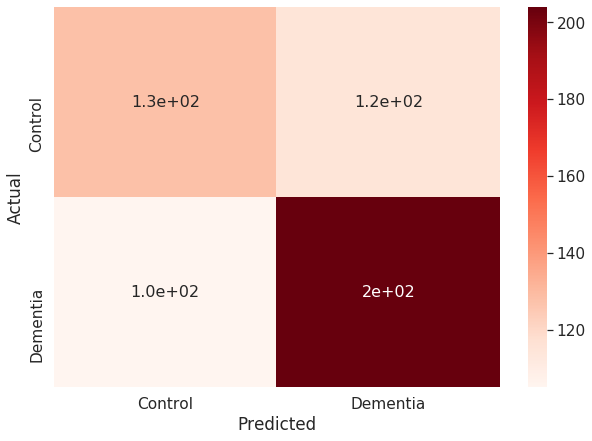

In [299]:
y_true = meta_pitt.Group
y_pred = meta_pitt.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 16})# font size

In [300]:
df_cm

Predicted,Control,Dementia
Actual,,
Control,128,115
Dementia,105,204


In [301]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     Control       0.55      0.53      0.54       243
    Dementia       0.64      0.66      0.65       309

    accuracy                           0.60       552
   macro avg       0.59      0.59      0.59       552
weighted avg       0.60      0.60      0.60       552



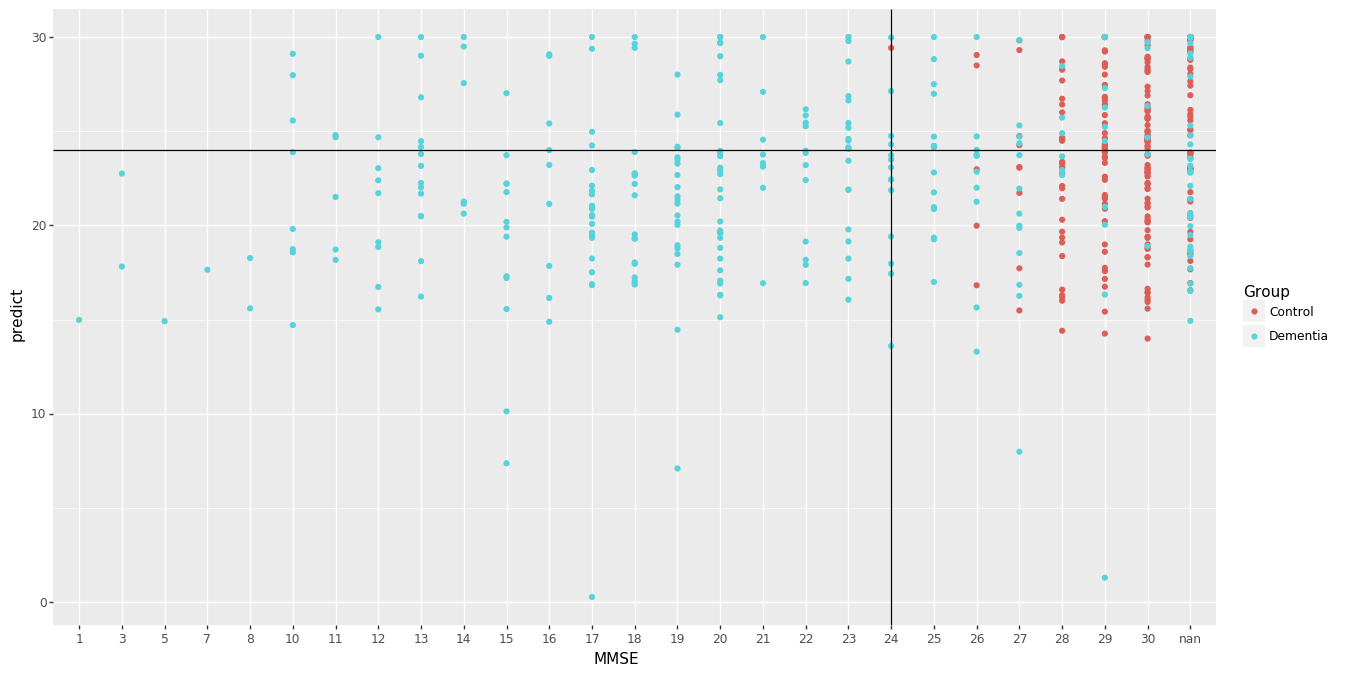

<ggplot: (8780796494600)>

In [310]:
ggplot(meta_pitt) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'Group')) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 20, lty = 2)) + \
theme(figure_size = (15, 8))